In [17]:
import algos
import bandit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

N_SWITCHES = 30
N_BANDITS = 20
OPT_SIZE = 6
HORIZON = 200
max_n_expert = len(list(combinations(np.arange(N_BANDITS),OPT_SIZE)))
# N_EXPERT = int(0.05*max_n_expert)
N_EXPERT = 10
assert N_EXPERT<=max_n_expert, f"The number of expert ({N_EXPERT}) must be smaller than the maximum combination ({max_n_expert})"
# assert N_BANDITS<=HORIZON, f"The number of arm ({N_BANDITS}) must be smaller than the horizon ({HORIZON})"

#MetaAlg params
N_UNBIASED_OBS = 1
ALG_NAME = 'ExpertMOSS'

EVAL_STEP = 1
N_EXPS = 5 #Repeat experiments
print(f'N_EXPERT = {N_EXPERT}')

N_EXPERT = 10


In [2]:
def rolls_out(agent, env, horizon):
    observations = []
    actions = []
    rewards = []
    next_observations = []
    obs = env.reset()
    for i in range(horizon):
        a = agent.get_action(obs)
        next_obs, r, _, _ = env.step(a)
        observations.append(obs)
        rewards.append(r)
        actions.append(a)
        next_observations.append(next_obs)
        obs = next_obs
        if hasattr(agent, 'update'): #For EXP3
            agent.update(a, r)
    if hasattr(agent, 'eps_end_update'): #For metaAlg
        agent.eps_end_update(obs)
    regret = np.max(env._p)*horizon - np.sum(rewards)
    return regret, dict(
        observations=np.array(observations),
        actions=np.array(actions),
        rewards=np.array(rewards),
        next_observations=np.array(next_observations),
    )

def meta_rolls_out(n_switches, agent, env, horizon):
    regrets = []
    tmp_regrets = []
    caches = []
    for idx in range(n_switches+1):
        env.reset_task(idx)
        r, c = rolls_out(agent, env, horizon)
        tmp_regrets.append(r)
        caches.append(c)
        regrets.append(np.average(tmp_regrets)) #average regret until this switch
    return regrets, caches

In [12]:
env = bandit.MetaBernoulli(n_bandits=N_BANDITS, opt_size=OPT_SIZE, n_tasks=N_SWITCHES+1, 
                           n_experts=N_EXPERT)

In [13]:
exp3_agent = algos.Exp3(n_bandits=N_BANDITS, horizon=HORIZON)
moss_agent = algos.MOSS(n_bandits=N_BANDITS, horizon=HORIZON)
# print(f'Optimal subgroup: {env.opt_indices}, all subgroups: {env.expert_subgroups}')

## Regret vs Number of switches

In [14]:
exp3_caches, moss_caches, meta_caches = [], [], []
meta_regrets = np.zeros((N_EXPS, N_SWITCHES+1))
exp3_regrets = np.zeros((N_EXPS, N_SWITCHES+1))
moss_regrets = np.zeros((N_EXPS, N_SWITCHES+1))
for i in range(N_EXPS):
    meta_agent = algos.MetaAlg(n_bandits=N_BANDITS, horizon=HORIZON, n_switches=N_SWITCHES, 
                      n_unbiased_obs=N_UNBIASED_OBS, alg_name=ALG_NAME, 
                      expert_subgroups=env.expert_subgroups)
    meta_r, meta_c = meta_rolls_out(N_SWITCHES, meta_agent, env, HORIZON)
    meta_caches.append(meta_c)
    meta_regrets[i] = meta_r
    exp3_r, exp3_c = meta_rolls_out(N_SWITCHES, exp3_agent, env, HORIZON)
    exp3_caches.append(exp3_c)
    exp3_regrets[i] = exp3_r
    moss_r, moss_c = meta_rolls_out(N_SWITCHES, moss_agent, env, HORIZON)
    moss_caches.append(moss_c)
    moss_regrets[i] = moss_r

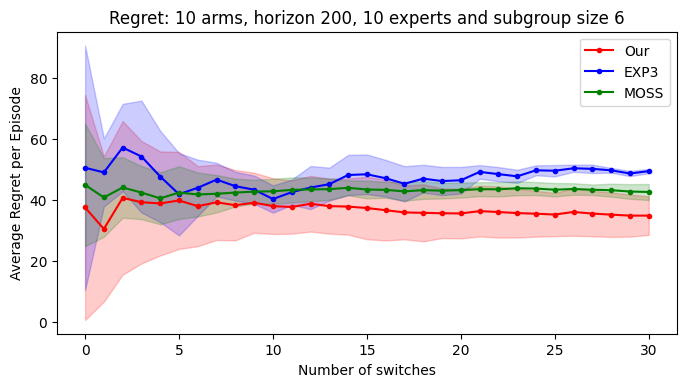

In [24]:
X = np.arange(N_SWITCHES+1)
meta_Y = np.mean(meta_regrets, axis=0)
meta_dY = 2*np.sqrt(np.var(meta_regrets, axis=0))
exp3_Y = np.mean(exp3_regrets, axis=0)
exp3_dY = 2*np.sqrt(np.var(exp3_regrets, axis=0))
moss_Y = np.mean(moss_regrets, axis=0)
moss_dY = 2*np.sqrt(np.var(moss_regrets, axis=0))
plt.plot(X, meta_Y, '.-', color='red', label = "Our")
plt.fill_between(X, meta_Y - meta_dY, meta_Y + meta_dY, color='red', alpha=0.2)
plt.plot(X, exp3_Y, '.-', color='blue', label = "EXP3")
plt.fill_between(X, exp3_Y - exp3_dY, exp3_Y + exp3_dY, color='blue', alpha=0.2)
plt.plot(X, moss_Y, '.-', color='green', label = "MOSS")
plt.fill_between(X, moss_Y - moss_dY, moss_Y + moss_dY, color='green', alpha=0.2)
plt.xlabel('Number of switches')
plt.ylabel('Average Regret per Episode')
# plt.yscale('log')
plt.legend()
plt.title(f'Regret: {N_BANDITS} arms, horizon {HORIZON}, {N_EXPERT} experts and subgroup size {OPT_SIZE}')
pass

## Regret vs Horizon

In [18]:
exp3_caches_h, moss_caches_h, meta_caches_h = [], [], []
horizon_list = np.arange(1,201,50)*10
meta_regrets_h = np.zeros((N_EXPS, horizon_list.shape[0]))
exp3_regrets_h = np.zeros((N_EXPS, horizon_list.shape[0]))
moss_regrets_h = np.zeros((N_EXPS, horizon_list.shape[0]))
for i in range(N_EXPS):
    for j, h in enumerate(horizon_list):
#         print(j, h)
        exp3_agent = algos.Exp3(n_bandits=N_BANDITS, horizon=h)
        moss_agent = algos.MOSS(n_bandits=N_BANDITS, horizon=h)
        meta_agent = algos.MetaAlg(n_bandits=N_BANDITS, horizon=h, n_switches=N_SWITCHES, 
                          n_unbiased_obs=N_UNBIASED_OBS, alg_name=ALG_NAME, 
                          expert_subgroups=env.expert_subgroups)
        meta_r, meta_c = meta_rolls_out(N_SWITCHES, meta_agent, env, h)
        meta_caches_h.append(meta_c)
        meta_regrets_h[i, j] = meta_r[-1]/h
        exp3_r, exp3_c = meta_rolls_out(N_SWITCHES, exp3_agent, env, h)
        exp3_caches_h.append(exp3_c)
        exp3_regrets_h[i, j] = exp3_r[-1]/h
        moss_r, moss_c = meta_rolls_out(N_SWITCHES, moss_agent, env, h)
        moss_caches_h.append(moss_c)
        moss_regrets_h[i, j] = moss_r[-1]/h

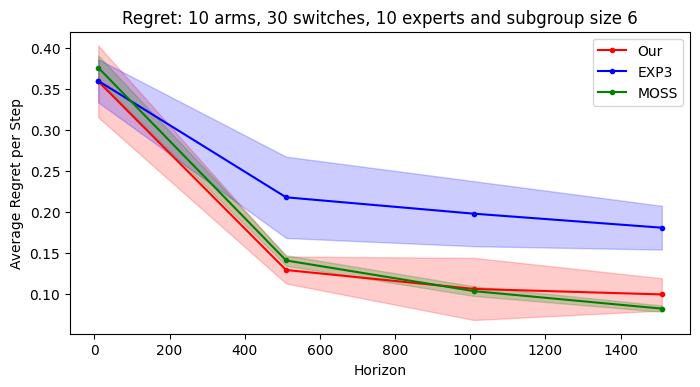

In [25]:
X = horizon_list
meta_Y = np.mean(meta_regrets_h, axis=0)
meta_dY = 2*np.sqrt(np.var(meta_regrets_h, axis=0))
exp3_Y = np.mean(exp3_regrets_h, axis=0)
exp3_dY = 2*np.sqrt(np.var(exp3_regrets_h, axis=0))
moss_Y = np.mean(moss_regrets_h, axis=0)
moss_dY = 2*np.sqrt(np.var(moss_regrets_h, axis=0))

plt.plot(X, meta_Y, '.-', color='red', label = "Our")
plt.fill_between(X, meta_Y - meta_dY, meta_Y + meta_dY, color='red', alpha=0.2)
plt.plot(X, exp3_Y, '.-', color='blue', label = "EXP3")
plt.fill_between(X, exp3_Y - exp3_dY, exp3_Y + exp3_dY, color='blue', alpha=0.2)
plt.plot(X, moss_Y, '.-', color='green', label = "MOSS")
plt.fill_between(X, moss_Y - moss_dY, moss_Y + moss_dY, color='green', alpha=0.2)
plt.xlabel('Horizon')
plt.ylabel('Average Regret per Step')
plt.legend()
plt.title(f'Regret: {N_BANDITS} arms, {N_SWITCHES} switches, {N_EXPERT} experts and subgroup size {OPT_SIZE}')
pass

## Regret vs # of arm

In [3]:
exp3_caches_b, moss_caches_b, meta_caches_b = [], [], []
n_bandits_list = np.arange(8,68,15)
meta_regrets_b = np.zeros((N_EXPS, n_bandits_list.shape[0]))
exp3_regrets_b = np.zeros((N_EXPS, n_bandits_list.shape[0]))
moss_regrets_b = np.zeros((N_EXPS, n_bandits_list.shape[0]))
for i in range(N_EXPS):
    for j, b in enumerate(n_bandits_list):
        env = bandit.MetaBernoulli(n_bandits=b, opt_size=OPT_SIZE, n_tasks=N_SWITCHES+1, 
                           n_experts=N_EXPERT)
        exp3_agent = algos.Exp3(n_bandits=b, horizon=HORIZON)
        moss_agent = algos.MOSS(n_bandits=b, horizon=HORIZON)
        meta_agent = algos.MetaAlg(n_bandits=b, horizon=HORIZON, n_switches=N_SWITCHES, 
                          n_unbiased_obs=N_UNBIASED_OBS, alg_name=ALG_NAME, 
                          expert_subgroups=env.expert_subgroups)
        meta_r, meta_c = meta_rolls_out(N_SWITCHES, meta_agent, env, HORIZON)
        meta_caches_b.append(meta_c)
        meta_regrets_b[i, j] = meta_r[-1]
        exp3_r, exp3_c = meta_rolls_out(N_SWITCHES, exp3_agent, env, HORIZON)
        exp3_caches_b.append(exp3_c)
        exp3_regrets_b[i, j] = exp3_r[-1]
        moss_r, moss_c = meta_rolls_out(N_SWITCHES, moss_agent, env, HORIZON)
        moss_caches_b.append(moss_c)
        moss_regrets_b[i, j] = moss_r[-1]

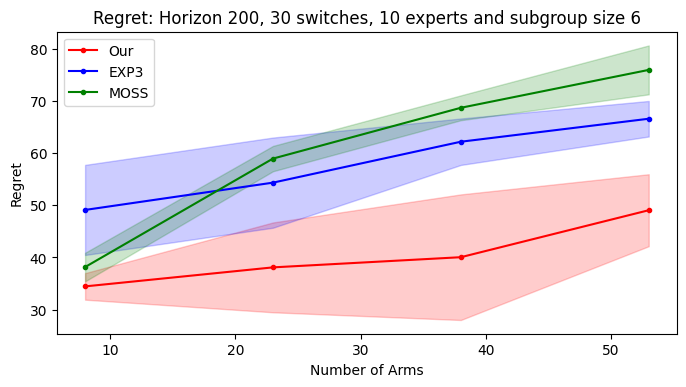

In [4]:
X = n_bandits_list
meta_Y = np.mean(meta_regrets_b, axis=0)
meta_dY = 2*np.sqrt(np.var(meta_regrets_b, axis=0))
exp3_Y = np.mean(exp3_regrets_b, axis=0)
exp3_dY = 2*np.sqrt(np.var(exp3_regrets_b, axis=0))
moss_Y = np.mean(moss_regrets_b, axis=0)
moss_dY = 2*np.sqrt(np.var(moss_regrets_b, axis=0))

plt.plot(X, meta_Y, '.-', color='red', label = "Our")
plt.fill_between(X, meta_Y - meta_dY, meta_Y + meta_dY, color='red', alpha=0.2)
plt.plot(X, exp3_Y, '.-', color='blue', label = "EXP3")
plt.fill_between(X, exp3_Y - exp3_dY, exp3_Y + exp3_dY, color='blue', alpha=0.2)
plt.plot(X, moss_Y, '.-', color='green', label = "MOSS")
plt.fill_between(X, moss_Y - moss_dY, moss_Y + moss_dY, color='green', alpha=0.2)
plt.xlabel('Number of Arms')
plt.ylabel('Regret')
plt.legend()
plt.title(f'Regret: Horizon {HORIZON}, {N_SWITCHES} switches, {N_EXPERT} experts and subgroup size {OPT_SIZE}')
pass

## Regret vs # of experts

In [6]:
exp3_caches_e, moss_caches_e, meta_caches_e = [], [], []
n_experts_list = np.arange(10,max_n_expert,20) #max_n_expert = 210 for 10 arms
meta_regrets_e = np.zeros((N_EXPS, n_experts_list.shape[0]))
exp3_regrets_e = np.zeros((N_EXPS, n_experts_list.shape[0]))
moss_regrets_e = np.zeros((N_EXPS, n_experts_list.shape[0]))
for i in range(N_EXPS):
    for j, e in enumerate(n_experts_list):
        env = bandit.MetaBernoulli(n_bandits=N_BANDITS, opt_size=OPT_SIZE, n_tasks=N_SWITCHES+1, 
                                   n_experts=e)
        exp3_agent = algos.Exp3(n_bandits=N_BANDITS, horizon=HORIZON)
        moss_agent = algos.MOSS(n_bandits=N_BANDITS, horizon=HORIZON)
        meta_agent = algos.MetaAlg(n_bandits=N_BANDITS, horizon=HORIZON, n_switches=N_SWITCHES, 
                          n_unbiased_obs=N_UNBIASED_OBS, alg_name=ALG_NAME, 
                          expert_subgroups=env.expert_subgroups)
        meta_r, meta_c = meta_rolls_out(N_SWITCHES, meta_agent, env, HORIZON)
        meta_caches_e.append(meta_c)
        meta_regrets_e[i, j] = meta_r[-1]
        exp3_r, exp3_c = meta_rolls_out(N_SWITCHES, exp3_agent, env, HORIZON)
        exp3_caches_e.append(exp3_c)
        exp3_regrets_e[i, j] = exp3_r[-1]
        moss_r, moss_c = meta_rolls_out(N_SWITCHES, moss_agent, env, HORIZON)
        moss_caches_e.append(moss_c)
        moss_regrets_e[i, j] = moss_r[-1]

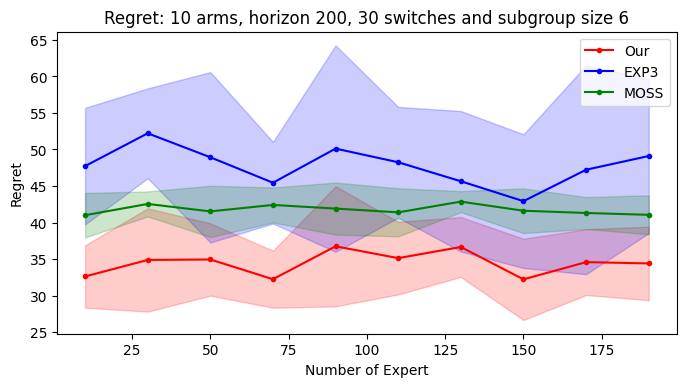

In [9]:
X = n_experts_list
meta_Y = np.mean(meta_regrets_e, axis=0)
meta_dY = 2*np.sqrt(np.var(meta_regrets_e, axis=0))
exp3_Y = np.mean(exp3_regrets_e, axis=0)
exp3_dY = 2*np.sqrt(np.var(exp3_regrets_e, axis=0))
moss_Y = np.mean(moss_regrets_e, axis=0)
moss_dY = 2*np.sqrt(np.var(moss_regrets_e, axis=0))

plt.plot(X, meta_Y, '.-', color='red', label = "Our")
plt.fill_between(X, meta_Y - meta_dY, meta_Y + meta_dY, color='red', alpha=0.2)
plt.plot(X, exp3_Y, '.-', color='blue', label = "EXP3")
plt.fill_between(X, exp3_Y - exp3_dY, exp3_Y + exp3_dY, color='blue', alpha=0.2)
plt.plot(X, moss_Y, '.-', color='green', label = "MOSS")
plt.fill_between(X, moss_Y - moss_dY, moss_Y + moss_dY, color='green', alpha=0.2)
plt.xlabel('Number of Expert')
plt.ylabel('Regret')
plt.legend()
plt.title(f'Regret: {N_BANDITS} arms, horizon {HORIZON}, {N_SWITCHES} switches and subgroup size {OPT_SIZE}')
pass

## Regret vs subgroup size

In [18]:
exp3_caches_s, moss_caches_s, meta_caches_s = [], [], []
opt_size_list = np.arange(1,N_BANDITS+1,4) #max_n_expert = 210 for 10 arms
meta_regrets_s = np.zeros((N_EXPS, opt_size_list.shape[0]))
exp3_regrets_s = np.zeros((N_EXPS, opt_size_list.shape[0]))
moss_regrets_s = np.zeros((N_EXPS, opt_size_list.shape[0]))
for i in range(N_EXPS):
    for j, s in enumerate(opt_size_list):
        env = bandit.MetaBernoulli(n_bandits=N_BANDITS, opt_size=s, n_tasks=N_SWITCHES+1, 
                                   n_experts=N_EXPERT)
        exp3_agent = algos.Exp3(n_bandits=N_BANDITS, horizon=HORIZON)
        moss_agent = algos.MOSS(n_bandits=N_BANDITS, horizon=HORIZON)
        meta_agent = algos.MetaAlg(n_bandits=N_BANDITS, horizon=HORIZON, n_switches=N_SWITCHES, 
                          n_unbiased_obs=N_UNBIASED_OBS, alg_name=ALG_NAME, 
                          expert_subgroups=env.expert_subgroups)
        meta_r, meta_c = meta_rolls_out(N_SWITCHES, meta_agent, env, HORIZON)
        meta_caches_s.append(meta_c)
        meta_regrets_s[i, j] = meta_r[-1]
        exp3_r, exp3_c = meta_rolls_out(N_SWITCHES, exp3_agent, env, HORIZON)
        exp3_caches_s.append(exp3_c)
        exp3_regrets_s[i, j] = exp3_r[-1]
        moss_r, moss_c = meta_rolls_out(N_SWITCHES, moss_agent, env, HORIZON)
        moss_caches_s.append(moss_c)
        moss_regrets_s[i, j] = moss_r[-1]

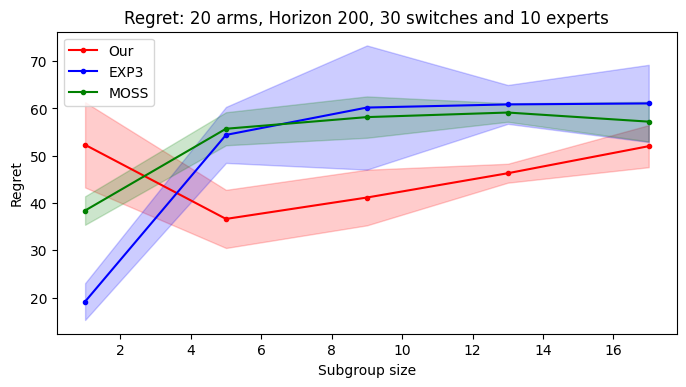

In [19]:
X = opt_size_list
meta_Y = np.mean(meta_regrets_s, axis=0)
meta_dY = 2*np.sqrt(np.var(meta_regrets_s, axis=0))
exp3_Y = np.mean(exp3_regrets_s, axis=0)
exp3_dY = 2*np.sqrt(np.var(exp3_regrets_s, axis=0))
moss_Y = np.mean(moss_regrets_s, axis=0)
moss_dY = 2*np.sqrt(np.var(moss_regrets_s, axis=0))

plt.plot(X, meta_Y, '.-', color='red', label = "Our")
plt.fill_between(X, meta_Y - meta_dY, meta_Y + meta_dY, color='red', alpha=0.2)
plt.plot(X, exp3_Y, '.-', color='blue', label = "EXP3")
plt.fill_between(X, exp3_Y - exp3_dY, exp3_Y + exp3_dY, color='blue', alpha=0.2)
plt.plot(X, moss_Y, '.-', color='green', label = "MOSS")
plt.fill_between(X, moss_Y - moss_dY, moss_Y + moss_dY, color='green', alpha=0.2)
plt.xlabel('Subgroup size')
plt.ylabel('Regret')
plt.legend()
plt.title(f'Regret: {N_BANDITS} arms, Horizon {HORIZON}, {N_SWITCHES} switches and {N_EXPERT} experts')
pass

In [9]:
# from collections import Counter
# print(regrets)
# c=Counter(cache['actions'])
# # print(c.most_common())
# print(f'Regret = {np.mean(regrets)} +/- {np.var(regrets)}.\nOptimal group = {env.opt_indices} \nActions = {c.most_common()}')